In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from datetime import timedelta, datetime

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_13832\326113220.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,year,week
0,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,1959,3
1,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,1959,2
2,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,1959,3
3,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,1959,3
4,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,1959,3


In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

In [3]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(["artist", "song_name"])["position"].transform("min")
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

## Average lifetime

In [4]:
def get_decade(year):
    return year - year % 10

billboard_hot_100["decade"] = billboard_hot_100["year"].apply(get_decade).astype(str) + "s"

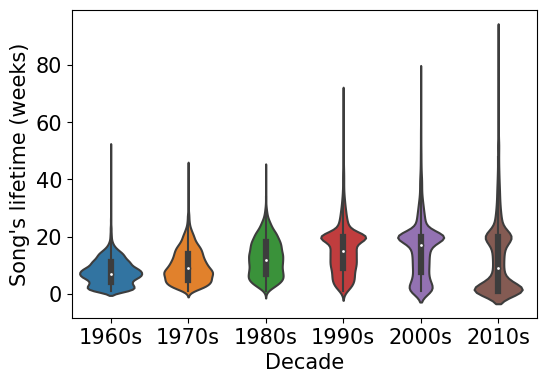

In [5]:
plt.figure(figsize=(6, 4))

billboard_hot_100_subset = billboard_hot_100[["artist", "song_name", "decade", "max_weeks_on_chart"]].drop_duplicates()
sns.violinplot(x='decade', y="max_weeks_on_chart", order=[str(decade) + "s" for decade in range(1960, 2020, 10)], data=billboard_hot_100_subset)

plt.xlabel("Decade")
plt.ylabel("Song's lifetime (weeks)")

plt.savefig("figures/lifeftime_distribution_per_decade.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Maximum weeks on chart distribution vs top position

In [6]:
def get_top_positions_range(position):
    if position <= 10:
        return "1-10"
    elif position <= 30:
        return "11-30"
    elif position <= 80:
        return "31-80"
    else:
        return "81-100"

billboard_hot_100["Top position range"] = billboard_hot_100["top_position"].map(
    lambda position: get_top_positions_range(position))
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " + billboard_hot_100["song_name"]

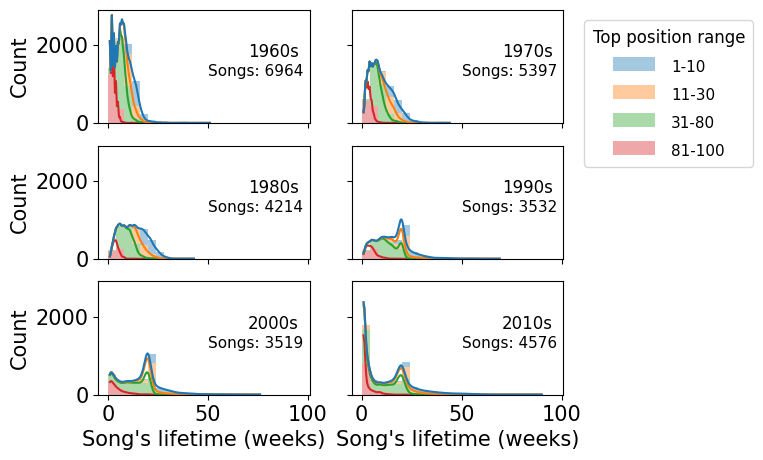

In [24]:
# plt.figure(figsize=(6, 4))
fig, axes = plt.subplots(3, 2, figsize=(6, 5), sharex=True, sharey=True)

col_i, row_i = 0, 0
histplots = []

for decade in range(1960, 2020, 10):
    billboard_hot_100_subset = billboard_hot_100[billboard_hot_100["decade"] == str(decade) + "s"]
    billboard_hot_100_subset = billboard_hot_100_subset[["artist_song", "Top position range", "max_weeks_on_chart"]].drop_duplicates()
    histplots.append(sns.histplot(data=billboard_hot_100_subset, x="max_weeks_on_chart", hue="Top position range", multiple="stack", bins=range(0, 100, 4),
                            label=str(decade) + "s", ax=axes[row_i, col_i], legend=(row_i == 0 and col_i == 1), kde=True, alpha=0.4,
                            edgecolor=None))

    # histplots.append(billboard_hot_100_subset.plot.area(x="max_weeks_on_chart", y="Top position range", ax=axes[row_i, col_i], legend=(row_i == 0 and col_i == 1)))
    number_of_songs_in_decade = billboard_hot_100_subset.shape[0]
    # billboard_hot_100_subset = billboard_hot_100[["artist_song", "Top position range", "max_weeks_on_chart"]].drop_duplicates()
    # histplot = sns.histplot(data=billboard_hot_100_subset, x="max_weeks_on_chart", hue="Top position range", multiple="stack", bins=range(0, 100, 3))
    axes[row_i, col_i].set_title(None)
    axes[row_i, col_i].text(70, 1700, f"{decade}s", fontsize=12)
    axes[row_i, col_i].text(50, 1200, f"Songs: {number_of_songs_in_decade}", fontsize=11)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Song's lifetime (weeks)")
    else:
        axes[row_i, col_i].set_xlabel(None)
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Count")
    else:
        axes[row_i, col_i].set_ylabel(None)
    #axes[row_i, col_i].set_xlim(right=70)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.setp(histplots[1].get_legend(), bbox_to_anchor=(1.05, 1))
# plt.setp(histplots[1].get_legend(), loc="upper left")
plt.setp(histplots[1].get_legend().get_title(), fontsize='12')
plt.setp(histplots[1].get_legend().get_texts(), fontsize='11')
plt.xlabel("Song's lifetime (weeks)")
plt.ylabel("Count")

plt.savefig("figures/max_weeks_on_chart_distribution_per_top_position_range.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

## Distribution of position changes for decades

In [8]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return np.NaN
    return last_week_position - position

billboard_hot_100["position_change"] = billboard_hot_100.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

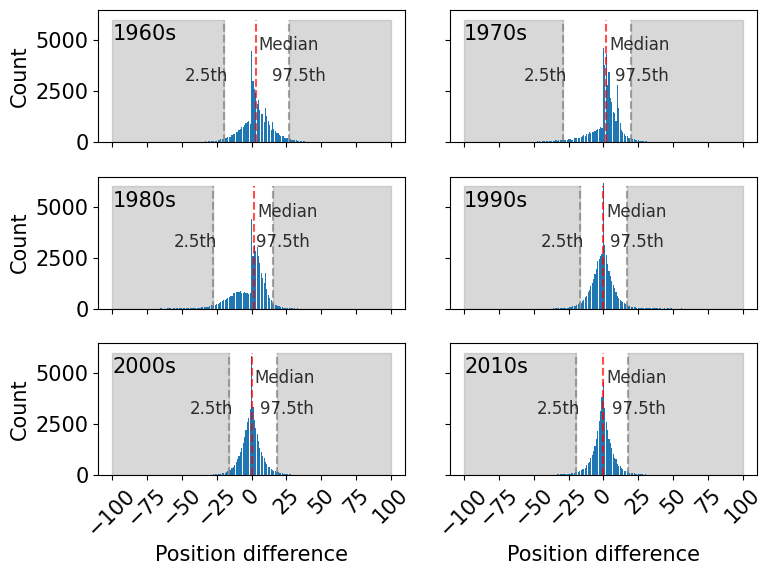

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = billboard_hot_100[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    decade_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=6000, color="grey", linestyle='--', alpha=0.7)
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=6000, color="grey", linestyle='--', alpha=0.7)
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=6000, color="red", linestyle='--', alpha=0.7)
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 28, 3000, "2.5th", size=12, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 12, 3000, "97.5th", size=12, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 2, 4500, "Median", size=12, alpha = 0.8)
    axes[row, col].bar(count_changes.index, count_changes.values)

    axes[row, col].text(-100, 5000, f"{year}s")

    if row == 2:
        axes[row, col].set_xlabel("Position difference")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Count")
    else:
        axes[row, col].set_ylabel(None)
    
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(45)

    col += 1
    if col == 2:
        col = 0
        row += 1

plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=10)
fig.tight_layout()
plt.savefig("figures/position_difference_distribution_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

C:\Users\cutie\AppData\Local\Temp\ipykernel_9636\1814276397.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


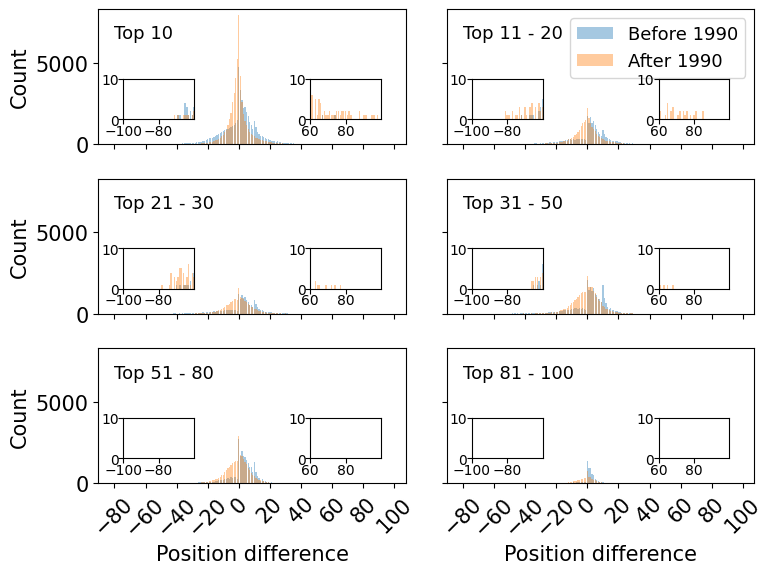

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = billboard_hot_100[["year", "first_day_of_the_week", "position_change", "top_position"]]
top_positions = [10, 20, 30, 50, 80, 100]

for i, top_position in enumerate(top_positions):
    if i > 0:
        data_subset = billboard_subset[(billboard_subset["top_position"] >= top_positions[i - 1] + 1) &\
            (billboard_subset["top_position"] <= top_position)][["year", "position_change"]]
    else:
        data_subset = billboard_subset[(billboard_subset["top_position"] >= 1) &\
            (billboard_subset["top_position"] <= top_position)][["year", "position_change"]]
    count_changes_prior_to_1990 = data_subset[data_subset["year"] < 1990]["position_change"].value_counts().sort_index()
    count_changes_after_1990 = data_subset[data_subset["year"] >= 1990]["position_change"].value_counts().sort_index()

    axes[row, col].bar(count_changes_prior_to_1990.index, count_changes_prior_to_1990.values, alpha=0.4)
    axes[row, col].bar(count_changes_after_1990.index, count_changes_after_1990.values, alpha=0.4)

    inner_ax = inset_axes(axes[row, col],
                width="23%",
                height="30%",
                loc=4,
                borderpad=1.2)
    inner_ax_left = inset_axes(axes[row, col],
                width="23%",
                height="30%",
                loc=3,
                borderpad=1.2)

    if i > 0:
        axes[row, col].text(-80, 6500, f"Top {top_positions[i - 1] + 1} - {top_position}", fontsize=13)
    else:
        axes[row, col].text(-80, 6500, f"Top {top_position}", fontsize=13)

    inner_ax.bar(count_changes_prior_to_1990.index, count_changes_prior_to_1990.values, alpha=0.4)
    inner_ax.bar(count_changes_after_1990.index, count_changes_after_1990.values, alpha=0.4)
    inner_ax.set_xlim(60, 100)
    inner_ax.tick_params(axis='both', which='major', labelsize=10, pad=-0.3)
    start, end = inner_ax.get_xlim()
    inner_ax.xaxis.set_ticks(np.arange(start, end, 20)) 
    inner_ax.set_ylim(0, 10)

    inner_ax_left.bar(count_changes_prior_to_1990.index, count_changes_prior_to_1990.values, alpha=0.4)
    inner_ax_left.bar(count_changes_after_1990.index, count_changes_after_1990.values, alpha=0.4)
    inner_ax_left.set_xlim(-100, -60)
    inner_ax_left.tick_params(axis='both', which='major', labelsize=10, pad=-0.3)
    start, end = inner_ax_left.get_xlim()
    inner_ax_left.xaxis.set_ticks(np.arange(start, end, 20)) 
    inner_ax_left.set_ylim(0, 10)

    if row == 0 and col == 1:
        axes[row, col].legend(["Before 1990", "After 1990"], loc="upper right", fontsize=13)
    if row == 2:
        axes[row, col].set_xlabel("Position difference")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Count")
    else:
        axes[row, col].set_ylabel(None)
    
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(45)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.savefig("figures/position_difference_distribution_top_positions.pdf", format="pdf", bbox_inches='tight')
plt.show()

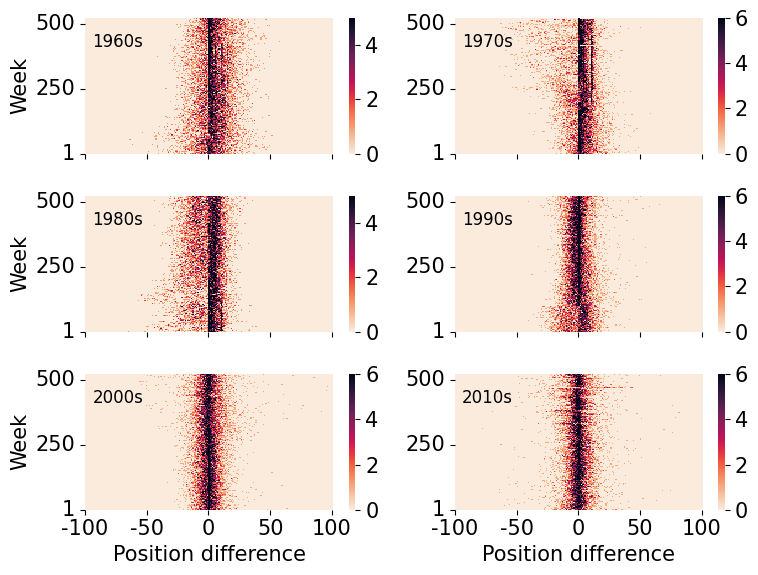

In [26]:
from scipy import ndimage

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True)

row = 0
col = 0

for year in range(1960, 2020, 10):
    billboard_year_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]
    cross_tab = pd.crosstab(billboard_year_subset["first_day_of_the_week"], 
                            billboard_year_subset["position_change"])
    # adding the non existing values between -100 and 100 as columns with 0 values to present in the heatmap
    not_existing = []
    for i in range(-100, 101):
        if i not in cross_tab.columns:
            not_existing.append(i)
    not_existing_dict = dict.fromkeys(not_existing, 0)        
    temp_df = pd.DataFrame(not_existing_dict, index=cross_tab.index)
    cross_tab = pd.concat([cross_tab, temp_df], axis=1)
    cross_tab = cross_tab.reindex(sorted(cross_tab.columns), axis=1)

    sns.heatmap(cross_tab, ax=axes[row, col], cmap=sns.color_palette("rocket_r", as_cmap=True), robust=True, rasterized=True)
    
    axes[row, col].text(6, 410, f"{year}s", fontsize=12)

    if row == 2:
        axes[row, col].set_xlabel("Position difference")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Week")
    else:
        axes[row, col].set_ylabel(None)
    axes[row, col].set_ylim(axes[row, col].get_ylim()[::-1])

    axes[row, col].set_yticks([0, 249, 499])
    axes[row, col].set_yticklabels(["1", "250", "500"])
    axes[row, col].set_xticks([0, 50, 100, 150, 200])
    axes[row, col].set_xticklabels(["-100", "-50", "0", "50", "100"])
    for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(0)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.savefig("figures/position_difference_heatmap_decades.pdf", format="pdf", bbox_inches='tight', dpi=150)
plt.show()

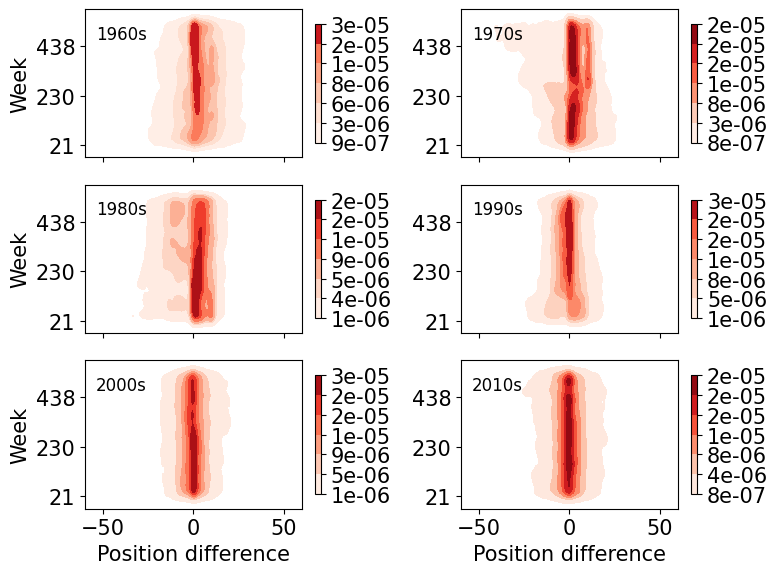

In [106]:
from matplotlib.ticker import FuncFormatter
import scipy.ndimage
fmt = lambda x, pos: '{:.0e}'.format(x)

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True)

row = 0
col = 0

for year in range(1960, 2020, 10):
    billboard_year_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]

    # https://github.com/mwaskom/seaborn/issues/917
    sns.kdeplot(billboard_year_subset, x=billboard_year_subset["position_change"], y=billboard_year_subset["first_day_of_the_week"], ax=axes[row, col], cmap="Reds", fill=True,
                cbar=True, bw_adjust=0.7, levels=7, cbar_kws={"format": FuncFormatter(fmt),"shrink": 0.8})

    axes[row, col].set_xlim(-60, 60)
    axes[row, col].text(0.05, 0.8, f"{year}s", transform=axes[row, col].transAxes, fontsize=12)

    if row == 2:
        axes[row, col].set_xlabel("Position difference")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Week")
    else:
        axes[row, col].set_ylabel(None)

    first_week = datetime(year, 1, 1)
    labels = [int((dateutil.parser.parse(item.get_text()) - first_week).days/7) + 1 for item in axes[row, col].get_yticklabels()][::2]
    # workaraound: https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator
    ticks_loc = axes[row, col].get_yticks().tolist()[::2]
    axes[row, col].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_yticklabels(labels)

    for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(0)

    col += 1 
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.savefig("figures/position_difference_contourmap_decades.pdf", format="pdf", bbox_inches='tight', dpi=150)
plt.show()

## Proportion of songs older than x for decades

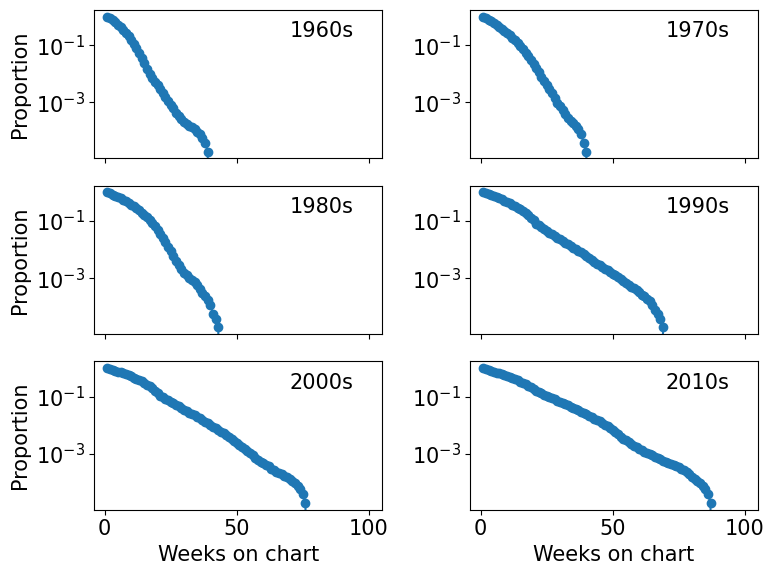

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    proportion_of_songs_older_than_x_weeks = []
    for i in range(1, 101):
        proportion_of_songs_older_than_x_weeks.append(
            billboard_hot_100[(billboard_hot_100["weeks_on_chart"] >= i) & (billboard_hot_100["year"] >= year) &\
                 (billboard_hot_100["year"] < year + 10)].shape[0] / billboard_hot_100[(billboard_hot_100["year"] >= year) &\
                 (billboard_hot_100["year"] < year + 10)].shape[0])
    axes[row, col].plot(range(1, 101), proportion_of_songs_older_than_x_weeks, marker='o')
    axes[row, col].text(70, 0.19, f"{year}s")

    if row == 2:
        axes[row, col].set_xlabel("Weeks on chart")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Proportion")
    else:
        axes[row, col].set_ylabel(None)
    axes[row, col].set_yscale("log")

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.savefig("figures/proportion_of_songs_older_than_x_weeks_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Position trajcetories of top 10 songs for decades

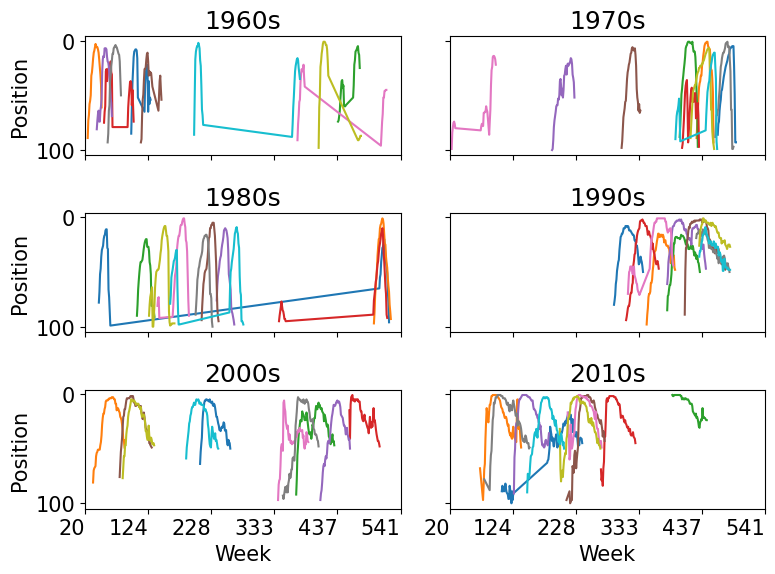

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max().reset_index()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade[~(max_weeks_on_chart_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            max_weeks_on_chart_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")

    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    top_10_decade_positions.groupby(by=["artist", "song_name"])["position"].plot(
        kind="line", legend=False, rot=0, ax=axes[row, col])

    axes[row, col].set_title(f"{year}s")
    if row == 2:
        axes[row, col].set_xlabel("Week")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Position")
    else:
        axes[row, col].set_ylabel(None)
    axes[row, col].set_xlim([datetime(year, 1, 1), datetime(year + 10, 1, 1)])

    first_week = datetime(year, 1, 1)
    labels = [int((dateutil.parser.parse(item.get_text()) - first_week).days/7) + 1 for item in axes[row, col].get_xticklabels()][::2]
    ticks_loc = axes[row, col].get_xticks().tolist()[::2]
    axes[row, col].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_xticklabels(labels, rotation=0)

    if row != 2:
        [tick.set_visible(False) for tick in axes[row, col].get_xticklabels()]


    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_positions_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Taking into consideration years before and after the decade

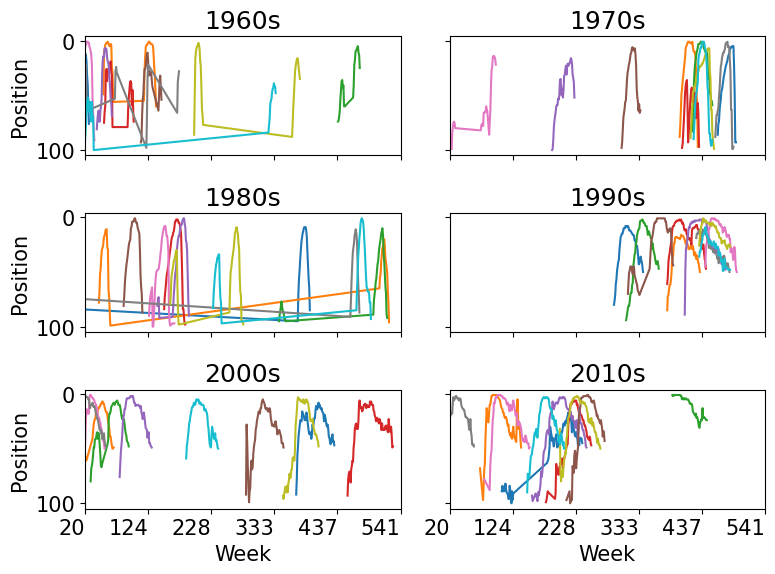

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].drop_duplicates().merge(
    billboard_hot_100, on=["artist", "song_name"], how="left")

    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    top_10_decade_positions.groupby(by=["artist", "song_name"])["position"].plot(
        kind="line", legend=False, rot=0, ax=axes[row, col])
    
    axes[row, col].set_title(f"{year}s")
    if row == 2:
        axes[row, col].set_xlabel("Week")
    else:
        axes[row, col].set_xlabel(None)
    if col == 0:
        axes[row, col].set_ylabel("Position")
    else:
        axes[row, col].set_ylabel(None)
    axes[row, col].set_xlim([datetime(year, 1, 1), datetime(year + 10, 1, 1)])

    first_week = datetime(year, 1, 1)
    labels = [int((dateutil.parser.parse(item.get_text()) - first_week).days/7) + 1 for item in axes[row, col].get_xticklabels()][::2]
    ticks_loc = axes[row, col].get_xticks().tolist()[::2]
    axes[row, col].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_xticklabels(labels, rotation=0)

    if row != 2:
        [tick.set_visible(False) for tick in axes[row, col].get_xticklabels()]

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_positions_decades_all_years.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Projection trajectory of a song normalized from top 1-10 for decades

In [7]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(["artist", "song_name"])["position"].transform("min")

In [5]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

In [6]:
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

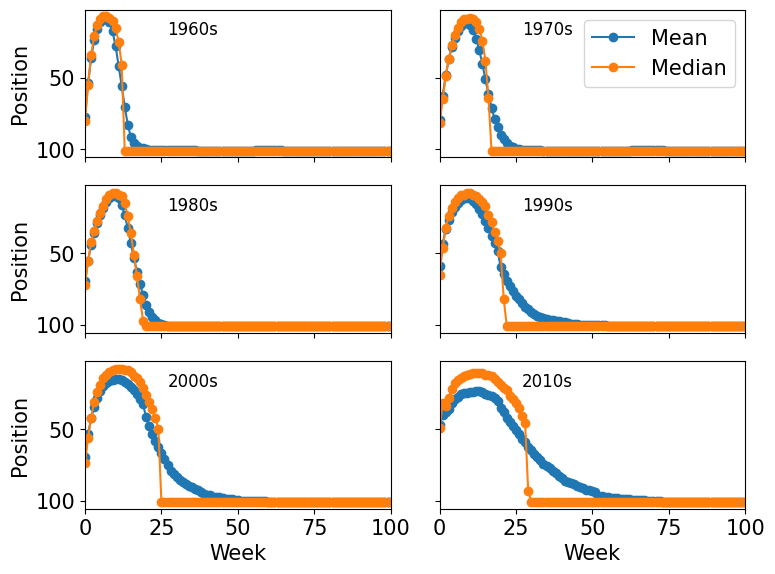

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 10)][["artist", "song_name"]]
    
    # take songs only from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
    top_10_positions_in_decade.sort_index(inplace=True)

    axes[row_i, col_i].plot(top_10_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_positions_in_decade.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].text(27, 20, f"{year}s", fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(["Mean", "Median"])
    axes[row_i, col_i].set_xlim([0, 100])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.xlim([0, 100])
plt.savefig("figures/top_1_10_positions_normalized_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Projection trajectory of a songs that never reached top 50 for decades

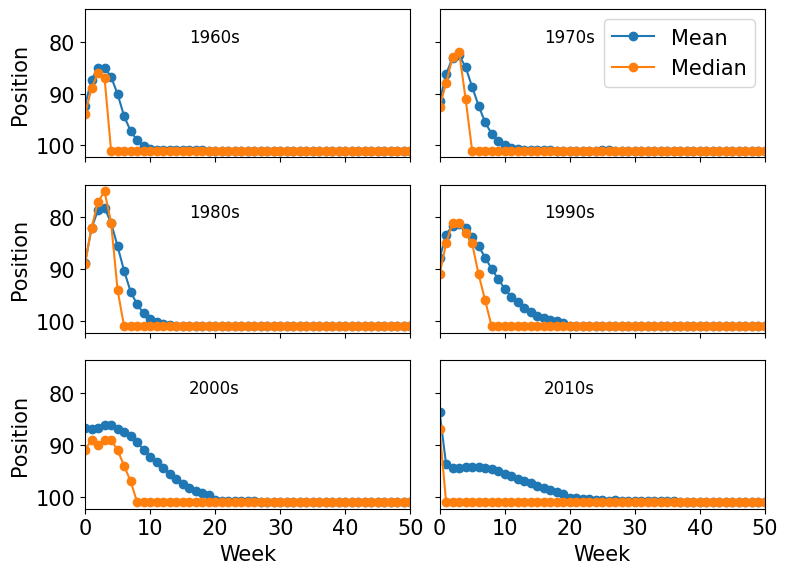

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 50)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))].copy()

    min_first_week = never_top_10_in_decade["first_day_of_the_week"].min().to_pydatetime()

    never_top_10_in_decade["first_day_of_the_week"] = never_top_10_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)
    never_top_10_in_decade.sort_index(inplace=True)

    axes[row_i, col_i].plot(never_top_10_in_decade.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(never_top_10_in_decade.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].text(16, 80, f"{year}s", fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(["Mean", "Median"])
    axes[row_i, col_i].set_xlim([0, 50])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/never_top_1_50_positions_normalized_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Histogram of start and end positions for decades

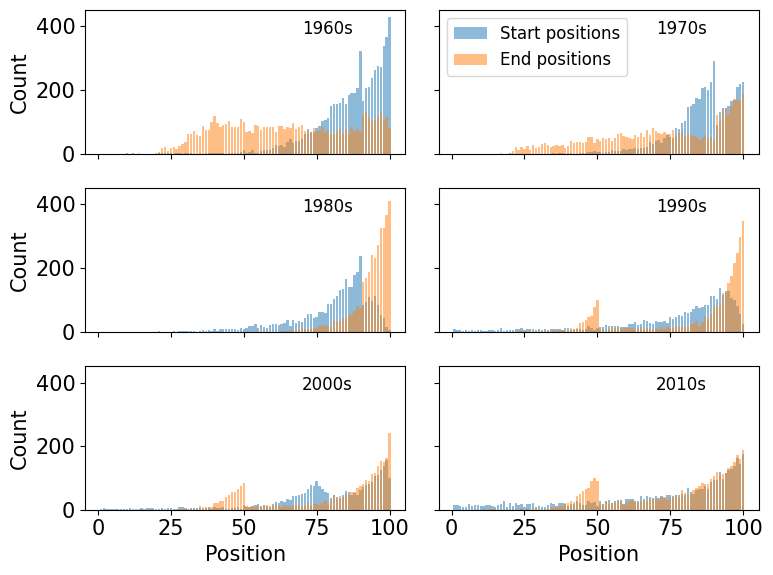

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    songs_from_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]

    start_weeks = songs_from_decade.groupby(["artist", "song_name"])["first_day_of_the_week"].min().reset_index()
    end_weeks = songs_from_decade.groupby(["artist", "song_name"])["first_day_of_the_week"].max().reset_index()

    start_positions = start_weeks.drop_duplicates().merge(songs_from_decade, on=["artist", "song_name", "first_day_of_the_week"])["position"]
    end_positions = end_weeks.drop_duplicates().merge(songs_from_decade, on=["artist", "song_name", "first_day_of_the_week"])["position"]

    count_start_positions = start_positions.value_counts().sort_index()
    count_end_positions = end_positions.value_counts().sort_index()

    axes[row_i, col_i].bar(count_start_positions.index, count_start_positions.values, alpha=0.5)
    axes[row_i, col_i].bar(count_end_positions.index, count_end_positions.values, alpha=0.5)
    
    axes[row_i, col_i].text(70, 375, f"{year}s", fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Position")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Count")
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(["Start positions", "End positions"], fontsize=12, loc="upper left")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/distribution_start_end_positions_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Max weeks on charts distribution for decades

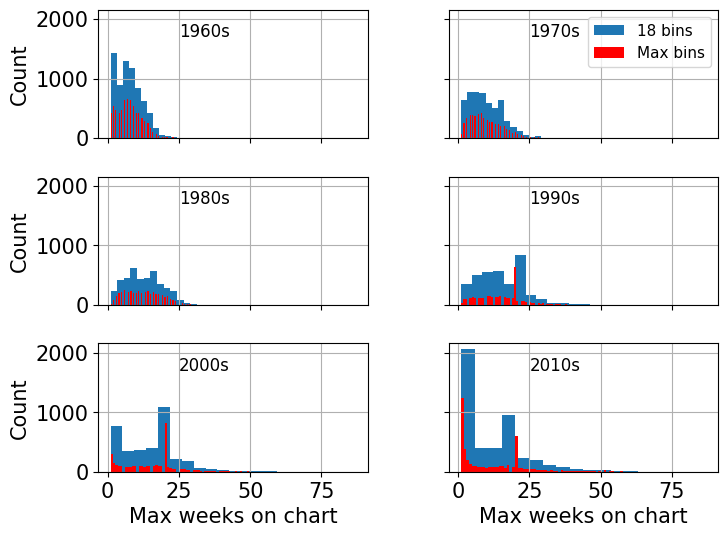

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    max_weeks_on_chart = all_songs_in_decade[["artist", "song_name", "weeks_on_chart"]].groupby(
        by=["artist", "song_name"]).max().reset_index()

    max_weeks_on_chart.hist(bins=18, figsize=(12, 8), legend=False, ax=axes[row_i, col_i])
    max_weeks_on_chart.hist(bins=billboard_hot_100["weeks_on_chart"].max(), figsize=(12, 8), legend=False, color="red", ax=axes[row_i, col_i])

    axes[row_i, col_i].set_title(None)
    axes[row_i, col_i].text(25, 1700, f"{year}s", fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Max weeks on chart")
    else:
        axes[row_i, col_i].set_xlabel(None)
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Count")
    else:
        axes[row_i, col_i].set_ylabel(None)
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(["18 bins", "Max bins"], fontsize=11, loc="upper right")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/max_weeks_on_chart_distribution_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()


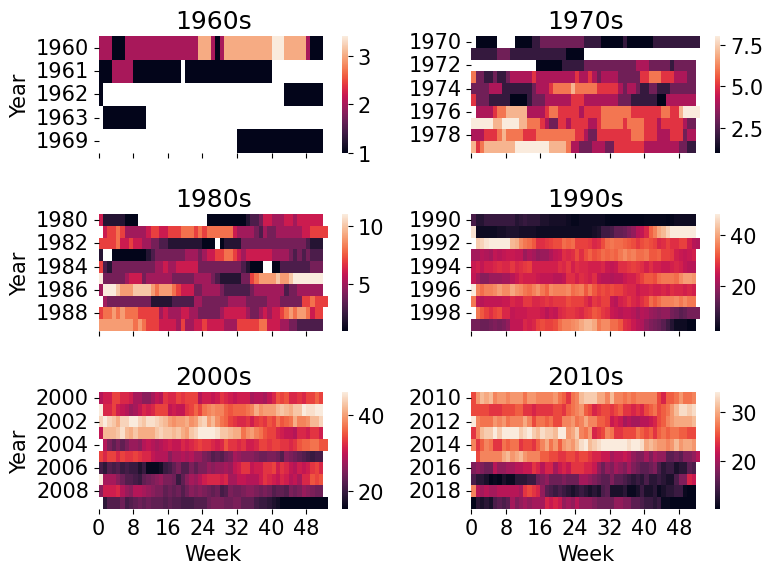

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    max_weeks_on_chart = all_songs_in_decade[["artist", "song_name", "weeks_on_chart"]].groupby(
        by=["artist", "song_name"]).max().reset_index()

    max_weeks_on_chart_20 = max_weeks_on_chart[max_weeks_on_chart["weeks_on_chart"] == 20]

    max_weeks_on_chart_20_df = max_weeks_on_chart_20[["artist", "song_name"]].drop_duplicates().merge(
        billboard_hot_100[(billboard_hot_100["year"] >= year) &\
            (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")

    sns.heatmap(max_weeks_on_chart_20_df[["year", "week"]].value_counts().unstack(),
        ax=axes[row_i, col_i], cmap=sns.color_palette("rocket", as_cmap=True), robust=True)
    axes[row_i, col_i].set_title(f"{year}s")
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    else:
        axes[row_i, col_i].set_xlabel(None)
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Year")
    else:
        axes[row_i, col_i].set_ylabel(None)

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))
    ticks_loc = [int(tick) for tick in axes[row_i, col_i].get_xticks().tolist()]
    axes[row_i, col_i].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row_i, col_i].set_xticklabels(ticks_loc, rotation = 0)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/heatmap_20_weeks_on_chart_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()


## Distributions of songs by same artists

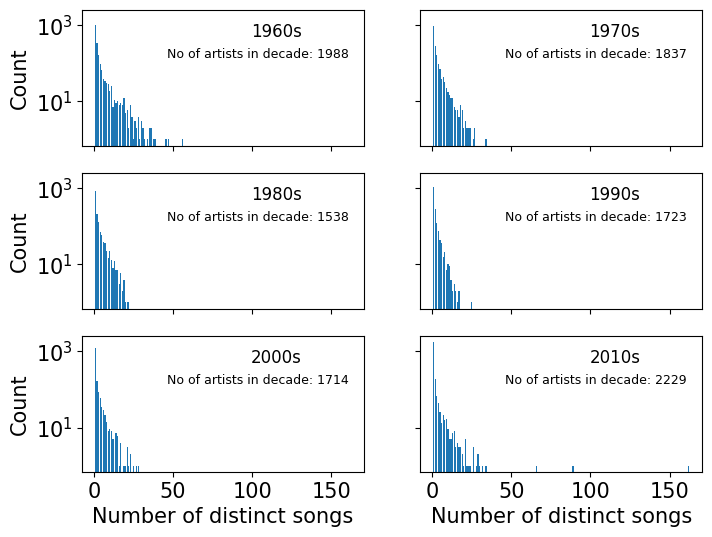

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    count_songs = all_songs_in_decade[["artist", "song_name"]].drop_duplicates().groupby(by="artist").count().reset_index()
    number_of_songs_distribution = count_songs["song_name"].value_counts()
    axes[row_i, col_i].bar(number_of_songs_distribution.index, number_of_songs_distribution.values)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Number of distinct songs")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Count")
    axes[row_i, col_i].set_yscale("log")
    axes[row_i, col_i].text(0.6, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    axes[row_i, col_i].text(0.3, 0.65, f"No of artists in decade: {len(count_songs)}", transform=axes[row_i, col_i].transAxes, fontsize=9)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/number_of_songs_per_artist_distribution.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Number of unique songs that reached positions

### Top 1-10, 11-20, 21-30..

In [ ]:
def get_top_positions_range(position):
    if position <= 10:
        return "1-10"
    elif position <= 20:
        return "11-20"
    elif position <= 30:
        return "21-30"
    elif position <= 40:
        return "31-40"
    elif position <= 50:
        return "41-50"
    elif position <= 60:
        return "51-60"
    elif position <= 70:
        return "61-70"
    elif position <= 80:
        return "71-80"
    elif position <= 90:
        return "81-90"
    else:
        return "91-100"

In [ ]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

billboard_hot_100["top_positions_range"] = billboard_hot_100["top_position"].map(
    lambda position: get_top_positions_range(position))

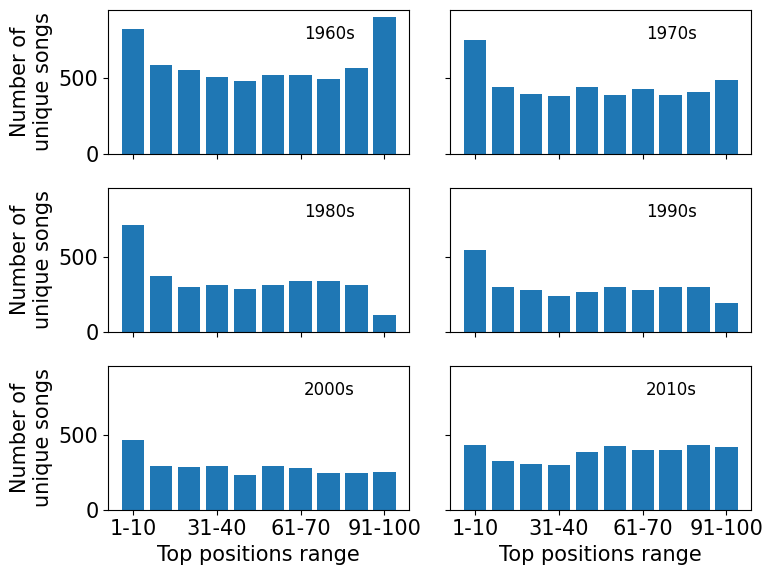

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    top_positions_grouped = songs_in_decade.groupby(["top_positions_range"])[["artist", "song_name"]].nunique().reset_index()
    axes[row_i, col_i].text(0.65, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Top positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Number of\nunique songs")
    axes[row_i, col_i].bar(top_positions_grouped["top_positions_range"], top_positions_grouped["song_name"])
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(4))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/number_of_unique_songs_per_top_positions_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Top 1-10, 1-20, 1-30..

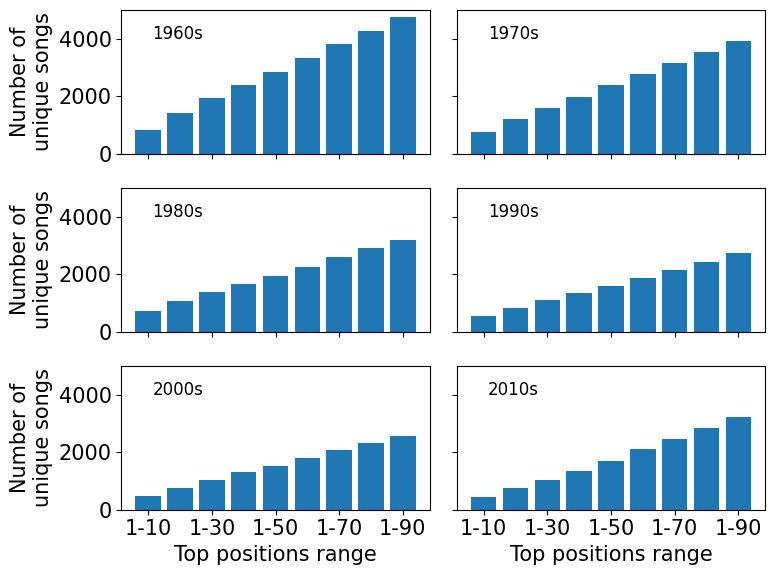

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    top_positions_grouped = pd.DataFrame(columns=["top_positions_range", "song_name"])
    for top_position in range(10, 100, 10):
        top_positions = songs_in_decade[songs_in_decade["top_position"] <= top_position][["artist", "song_name"]].nunique(
            )
        new_row = pd.DataFrame({"top_positions_range": f"1-{top_position}",
            "song_name": top_positions["song_name"]}, index=[0])
        top_positions_grouped = pd.concat([top_positions_grouped, new_row])

    axes[row_i, col_i].bar(top_positions_grouped["top_positions_range"], top_positions_grouped["song_name"])
    axes[row_i, col_i].text(0.1, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Top positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Number of\nunique songs")
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(5))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/number_of_unique_songs_per_top_positions_increasing_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Bottom 90-100, 80-100, 70-100..

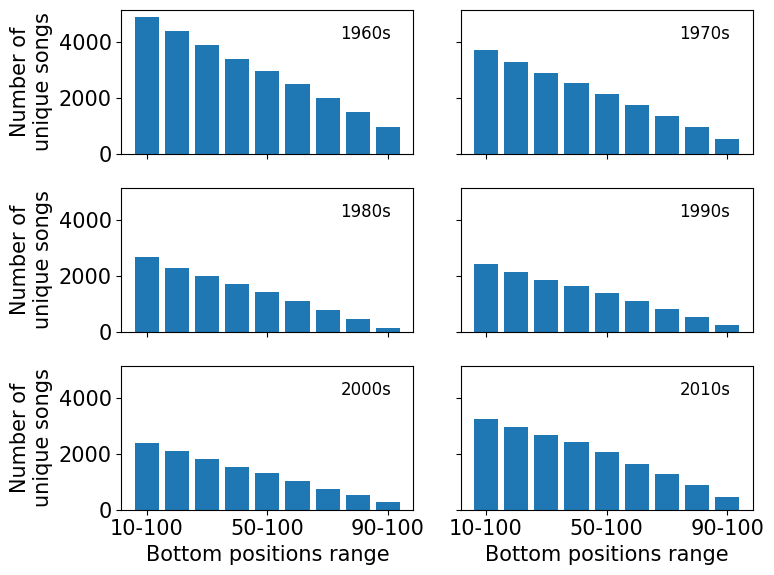

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    bottom_positions_grouped = pd.DataFrame(columns=["bottom_positions_range", "song_name"])
    for bottom_position in range(90, 1, -10):
        bottom_positions = songs_in_decade[songs_in_decade["top_position"] >= bottom_position][["artist", "song_name"]].nunique(
            )
        new_row = pd.DataFrame({"bottom_positions_range": f"{bottom_position}-100",
            "song_name": bottom_positions["song_name"]}, index=[0])
        bottom_positions_grouped = pd.concat([bottom_positions_grouped, new_row])

    axes[row_i, col_i].bar(bottom_positions_grouped["bottom_positions_range"], bottom_positions_grouped["song_name"])
    axes[row_i, col_i].text(0.75, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Bottom positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Number of\nunique songs")
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(3))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_xaxis()
plt.savefig("figures/number_of_unique_songs_per_bottom_position_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Average number of past weeks on the chart (before the top position)

In [42]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

In [43]:
df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

In [44]:
billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

## Expected future weeks on the chart (after top position)

In [45]:
def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [46]:
df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

In [47]:
billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

## Average number of max/future/past weeks on the chart

In [41]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

### Top 1-10, 1-20, 1-30..

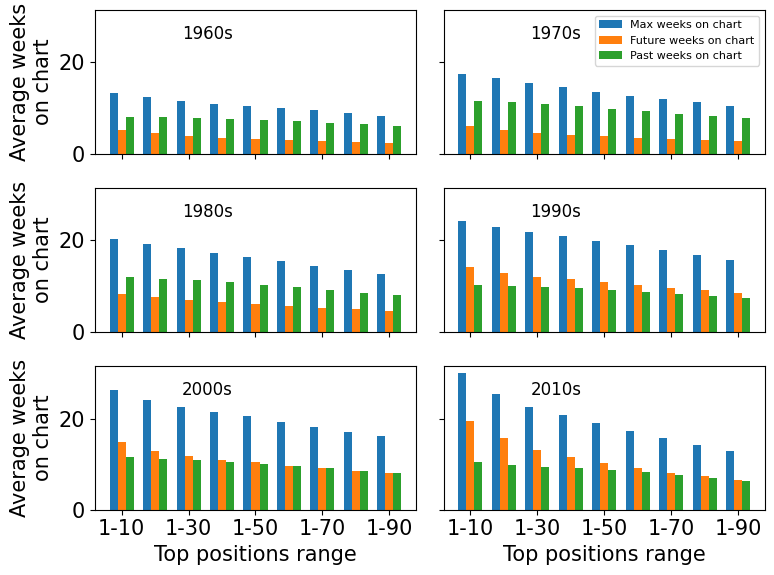

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    top_positions_max = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    top_positions_future = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    top_positions_past = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    for top_position in range(10, 100, 10):
        avg_max_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position)].groupby(
                ["artist", "song_name"])["max_weeks_on_chart"].first().mean()
        new_row_max = pd.DataFrame({"top_positions_range": f"1-{top_position}",
            "avg_weeks": avg_max_weeks}, index=[0])
        top_positions_max = pd.concat([top_positions_max, new_row_max])

        avg_future_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position)].groupby(
                ["artist", "song_name"])["future_weeks"].first().mean()
        new_row_future = pd.DataFrame({"top_positions_range": f"1-{top_position}",
            "avg_weeks": avg_future_weeks}, index=[0])
        top_positions_future = pd.concat([top_positions_future, new_row_future])

        avg_past_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position)].groupby(
                ["artist", "song_name"])["past_weeks"].first().mean()
        new_row_past = pd.DataFrame({"top_positions_range": f"1-{top_position}",
            "avg_weeks": avg_past_weeks}, index=[0])
        top_positions_past = pd.concat([top_positions_past, new_row_past])

    ind = np.arange(top_positions_max["top_positions_range"].shape[0])
    bar_width = 0.24
    axes[row_i, col_i].bar(ind, top_positions_max["avg_weeks"], bar_width, label="Max weeks on chart")
    axes[row_i, col_i].bar(ind + bar_width, top_positions_future["avg_weeks"], bar_width, label="Future weeks on chart")
    axes[row_i, col_i].bar(ind + 2*bar_width, top_positions_past["avg_weeks"], bar_width, label="Past weeks on chart")
    axes[row_i, col_i].text(0.27, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Top positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Average weeks\non chart")
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[row_i, col_i].set_xticks(ind[::2] + bar_width, top_positions_max["top_positions_range"].tolist()[::2])
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=8)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/average_weeks_on_chart_per_top_position_increasing_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Top 1-10, 11-20, 21-30..

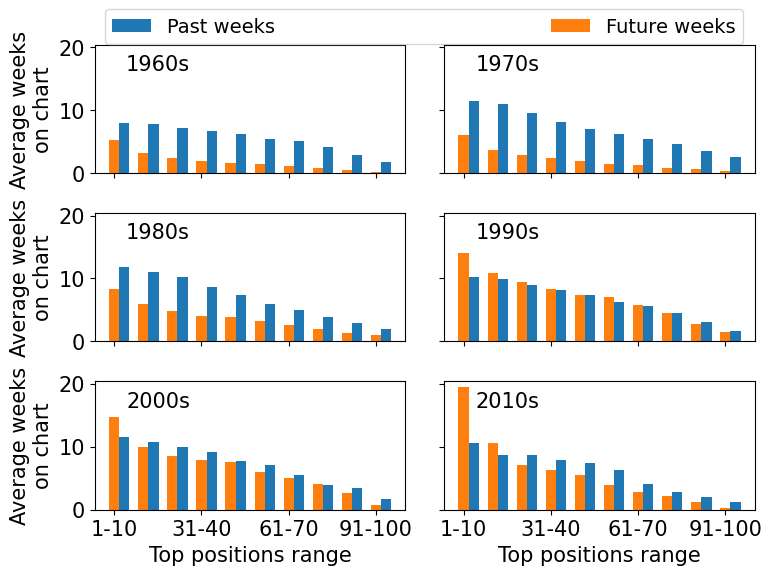

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    top_positions_max = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    top_positions_future = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    top_positions_past = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    for top_position in range(10, 110, 10):
        avg_max_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position) &\
            (songs_in_decade["top_position"] > top_position - 10)].groupby(
                ["artist", "song_name"])["max_weeks_on_chart"].first().mean()
        new_row_max = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
            "avg_weeks": avg_max_weeks}, index=[0])
        top_positions_max = pd.concat([top_positions_max, new_row_max])

        avg_future_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position) &\
            (songs_in_decade["top_position"] > top_position - 10)].groupby(
                ["artist", "song_name"])["future_weeks"].first().mean()
        new_row_future = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
            "avg_weeks": avg_future_weeks}, index=[0])
        top_positions_future = pd.concat([top_positions_future, new_row_future])

        avg_past_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position) &\
            (songs_in_decade["top_position"] > top_position - 10)].groupby(
                ["artist", "song_name"])["past_weeks"].first().mean()
        new_row_past = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
            "avg_weeks": avg_past_weeks}, index=[0])
        top_positions_past = pd.concat([top_positions_past, new_row_past])

    ind = np.arange(top_positions_max["top_positions_range"].shape[0])
    # bar_width = 0.24
    bar_width = 0.35
    # axes[row_i, col_i].bar(ind, top_positions_max["avg_weeks"], bar_width, label="Max weeks")
    axes[row_i, col_i].bar(ind + 2*bar_width, top_positions_past["avg_weeks"], bar_width, label="Past weeks")
    axes[row_i, col_i].bar(ind + bar_width, top_positions_future["avg_weeks"], bar_width, label="Future weeks")
    axes[row_i, col_i].text(0.1, 0.8, f"{year}s", fontsize=15, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Top positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Average weeks\non chart")
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axes[row_i, col_i].set_xticks(ind[::3] + bar_width, top_positions_max["top_positions_range"].tolist()[::3])
    if row_i == 0 and col_i == 0:
        axes[row_i, col_i].legend(fontsize=14, loc="lower left", bbox_to_anchor=(0, 0.93, 2.12, 0.2), ncols=3, mode="expand")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/average_weeks_on_chart_per_top_position_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Bottom 90-100, 80-100, 70-100..

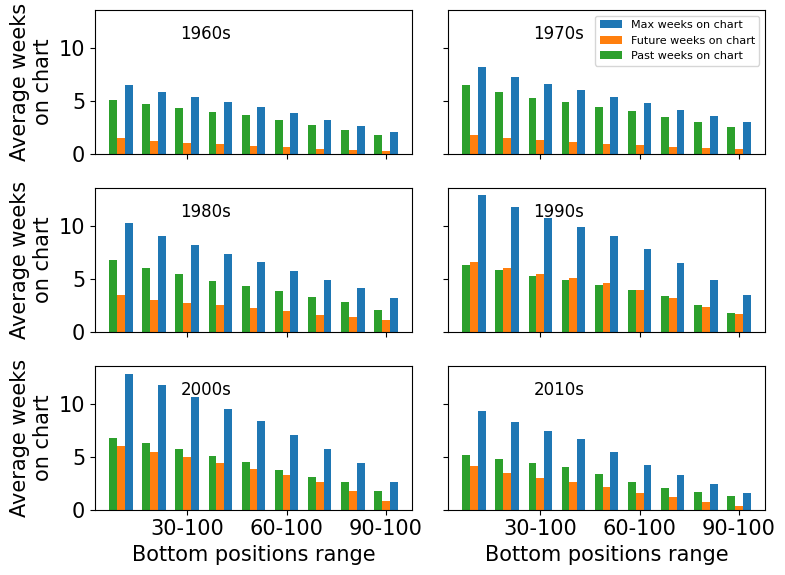

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    bottom_positions_max = pd.DataFrame(columns=["bottom_positions_range", "avg_weeks"])
    bottom_positions_future = pd.DataFrame(columns=["bottom_positions_range", "avg_weeks"])
    bottom_positions_past = pd.DataFrame(columns=["bottom_positions_range", "avg_weeks"])
    for bottom_position in range(90, 1, -10):
        avg_max_weeks = songs_in_decade[songs_in_decade["top_position"] >= bottom_position].groupby(
                ["artist", "song_name"])["max_weeks_on_chart"].first().mean()
        new_row_max = pd.DataFrame({"bottom_positions_range": f"{bottom_position}-100",
            "avg_weeks": avg_max_weeks}, index=[0])
        bottom_positions_max = pd.concat([bottom_positions_max, new_row_max])

        avg_future_weeks = songs_in_decade[songs_in_decade["top_position"] >= bottom_position].groupby(
                ["artist", "song_name"])["future_weeks"].first().mean()
        new_row_future = pd.DataFrame({"bottom_positions_range": f"{bottom_position}-100",
            "avg_weeks": avg_future_weeks}, index=[0])
        bottom_positions_future = pd.concat([bottom_positions_future, new_row_future])

        avg_past_weeks = songs_in_decade[songs_in_decade["top_position"] >= bottom_position].groupby(
                ["artist", "song_name"])["past_weeks"].first().mean()
        new_row_past = pd.DataFrame({"bottom_positions_range": f"{bottom_position}-100",
            "avg_weeks": avg_past_weeks}, index=[0])
        bottom_positions_past = pd.concat([bottom_positions_past, new_row_past])

    ind = np.arange(bottom_positions_max["bottom_positions_range"].shape[0])
    bar_width = 0.24
    axes[row_i, col_i].bar(ind, bottom_positions_max["avg_weeks"], bar_width, label="Max weeks on chart")
    axes[row_i, col_i].bar(ind + bar_width, bottom_positions_future["avg_weeks"], bar_width, label="Future weeks on chart")
    axes[row_i, col_i].bar(ind + 2*bar_width, bottom_positions_past["avg_weeks"], bar_width, label="Past weeks on chart")

    axes[row_i, col_i].text(0.27, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Bottom positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Average weeks\non chart")
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axes[row_i, col_i].set_xticks(ind[::3] + bar_width, bottom_positions_max["bottom_positions_range"].tolist()[::3])
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=8)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_xaxis()
plt.savefig("figures/average_weeks_on_chart_per_bottom_position_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Max weeks on charts vs top position

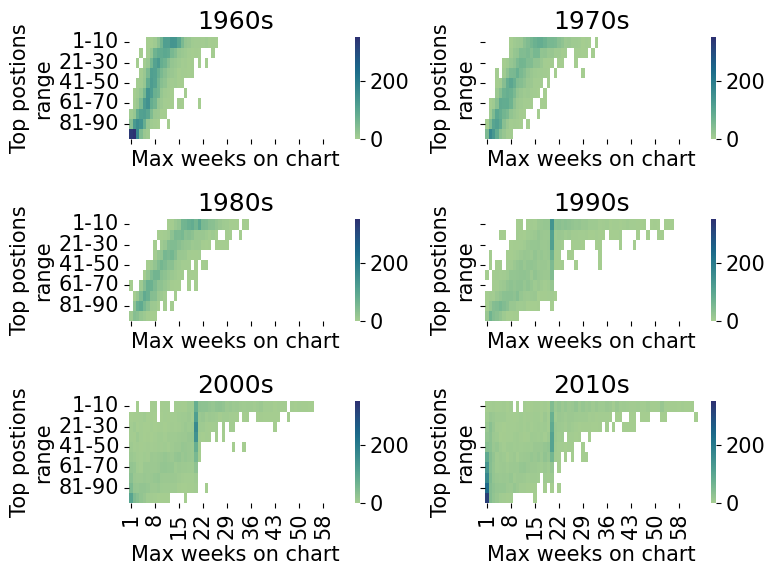

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]

    songs_in_decade = songs_in_decade[["artist", "song_name", "top_positions_range", "max_weeks_on_chart"]].drop_duplicates()
    heatmap_data = songs_in_decade[["top_positions_range", "max_weeks_on_chart"]].value_counts().unstack()
    sns.heatmap(heatmap_data, ax=axes[row_i, col_i], cmap="crest", vmin=0, vmax=350)

    axes[row_i, col_i].set_title(f"{year}s")
    axes[row_i, col_i].set_ylabel("Top postions\nrange")
    axes[row_i, col_i].set_xlabel("Max weeks on chart")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/max_weeks_on_chart_per_top_position_decades_heatmap.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Average weeks on chart vs top position

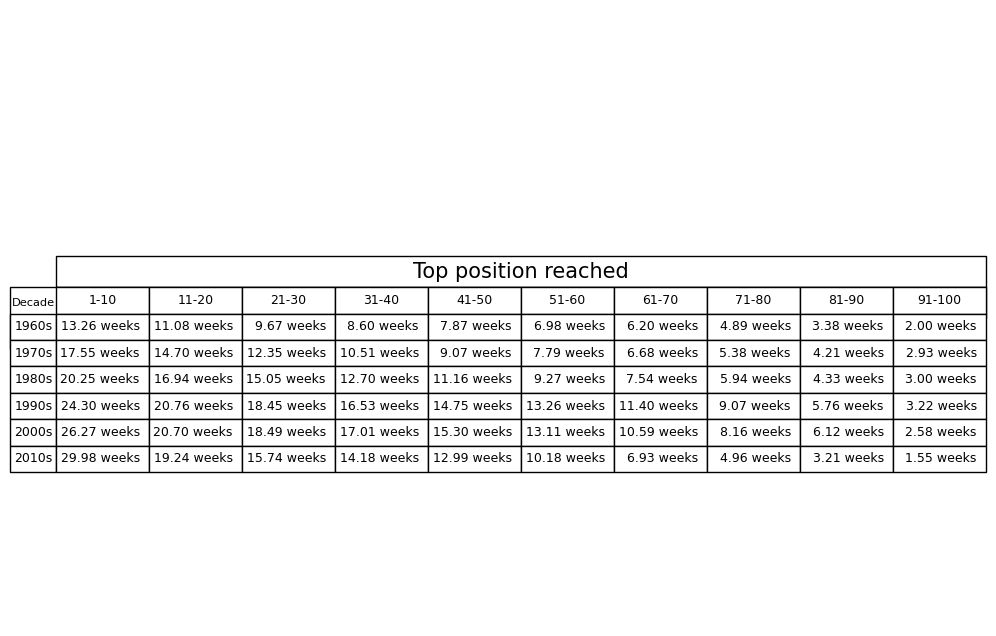

In [ ]:
top_positions_max = pd.DataFrame(columns=["top_positions_range", "avg_weeks", "decade"])

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade
    songs_in_decade = billboard_hot_100[~(billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"]))]

    for top_position in range(10, 110, 10):
        avg_max_weeks = songs_in_decade[(songs_in_decade["top_position"] <= top_position) &\
            (songs_in_decade["top_position"] > top_position - 10)].groupby(
                ["artist", "song_name"])["max_weeks_on_chart"].first().mean()
        new_row_max = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
            "avg_weeks": avg_max_weeks, "decade": year}, index=[0])
        top_positions_max = pd.concat([top_positions_max, new_row_max])

top_positions_max.update(top_positions_max["avg_weeks"].map('{:,.2f} weeks'.format))
top_positions_max.update(top_positions_max["decade"].map('{:}s'.format))
top_positions_max = top_positions_max.pivot(index="decade", columns="top_positions_range", values="avg_weeks")

plt.figure(figsize=(12, 8))

header = plt.table(cellText=[['']],
                    colLabels=['Top position reached'],
                    loc='center',
                    bbox=[0, 0.5, 1, 0.1])
header2 = plt.table(cellText=[['']],
                    colLabels=['Decade'],
                    loc='center',
                    bbox=[-0.049, 0.45, 0.05, 0.1])
header2.auto_set_font_size(False)
header2.set_fontsize(8.2)

table = plt.table(cellText=top_positions_max.values,
        rowLabels=top_positions_max.index.tolist(),
        colLabels=top_positions_max.columns.tolist(),
        loc='center',
        bbox=[0, 0.25, 1.0, 0.3])
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(9)

plt.axis("off")
plt.savefig("figures/average_weeks_on_chart_per_top_position_decades_table.pdf", format="pdf", bbox_inches='tight')
plt.show()

## All average trajectories for positions 1-10, 11-20, 21-30..

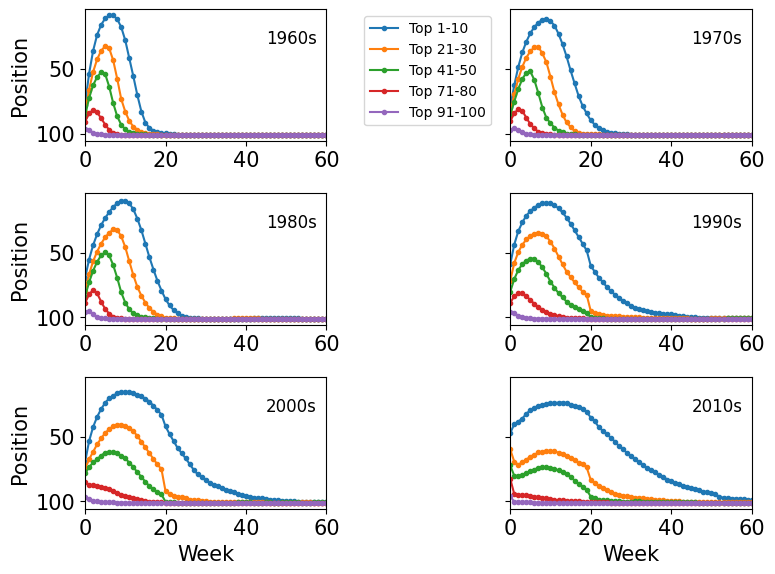

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "top_position", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    for top_position, low_positions in [(1, 10),  (21, 30), (41, 50), (71, 80), (91, 100)]:
        # songs that reached top 50 in the decade
        top_x_positions_in_decade = all_songs_in_decade[(all_songs_in_decade["top_position"] <= low_positions) &\
            (all_songs_in_decade["top_position"] >= top_position)][["artist", "song_name"]]

        # take songs only from this decade
        top_x_positions_in_decade = top_x_positions_in_decade[~(top_x_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_x_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]

        # take all positions of the songs
        top_x_positions_in_decade = top_x_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist", "song_name",
                "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

        min_first_week = top_x_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

        top_x_positions_in_decade["first_day_of_the_week"] = top_x_positions_in_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        top_x_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
        top_x_positions_in_decade.sort_index(inplace=True)

        axes[row_i, col_i].plot(top_x_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
            marker='o', label=f"Top {top_position}-{low_positions}", ms=3)

    axes[row_i, col_i].text(45, 30, f"{year}s", fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=10, bbox_to_anchor=(-0.05, 1))
    axes[row_i, col_i].set_xlim([0, 60])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/average_position_change_per_top_position_decades.pdf", format="pdf", bbox_inches='tight')
plt.show()